# **Sessa Empirical Estimator (SEE) Implementation in Python**

## **Section 1: What is the Sessa Empirical Estimator (SEE)?**

Sessa Empirical Estimator (SEE) is a new data-driven method that utilizes K-Means Clustering for computing the duration of pharmacological prescriptions in secondary data sources when this information is missing or incomplete. It aims to compute the duration of filled prescriptions when information about the true duration isn't available. It relies on the availability of individual-level information on the date of filling of a medicinal product for computing the duration of filled prescriptions.

This method relies on a couple of assumptions:
1. The duration of a filled prescription is associated with the temporal distance between subsequently filled prescriptions.
2. The amount dispensed is consumed by the patient during the time between two filled prescriptions

## **Section 2: How does SEE work?**
The steps of carrying out this procedure are as follows:
Okay, here are the rephrased steps, aiming for clarity and conciseness:

1.  **Calculate the Distribution of Prescription Intervals:** For all patients, the algorithm analyzes the time gaps between consecutive prescription refills within a set observation period. It creates a cumulative distribution function (ECDF) representing these time gaps. To focus on typical refill patterns and exclude outliers from patients who start or stop medication early or late, only the shortest 80% of the observed time gaps are considered.

2.  **Randomly Select a Prescription Pair:** For each patient in the study, the algorithm randomly chooses one pair of consecutively filled prescriptions within the observation window.

3.  **Group Similar Time Gaps:** The time gap between the randomly selected prescription pair is standardized. Then, the algorithm uses K-means clustering to group these standardized time gaps into *K* distinct clusters, where *K* is chosen to minimize the variation within each group. Silhouette analysis is employed to determine the optimal number of clusters.

4.  **Determine Typical Duration for Each Group:** For each cluster of prescription time gaps, the algorithm calculates the probability density function and identifies the median time gap. This median value represents the typical duration of prescriptions within that specific cluster.

5.  **Estimate Prescription End Dates:** Finally, for each filled prescription, the algorithm uses the typical duration calculated for its cluster to estimate the prescription's end date or "days of supply."

> 🔥 Methods of Clustering Analysis
> 
> To uncover groups of patients with similar prescription behaviors, we employ two different methods of clustering:
> 1. Hierarchical Clustering
> 2. K-means Clustering



## Clustering Analysis:
To uncover groups of patients with similar prescription behaviors, we employ two different methods of clustering:
1. Hierarchical Clustering
2. K-means Clustering


### K-Means Clustering:
We implement k-means clustering to segment patients into clusters. An optimal number of clusters is selected using silhouette analysis. For each cluster, we compute centroids and derive cluster boundaries, which are then used to assign patients to final clusters.

### Hierarchical Clustering:
Using Ward's method, we create dendrograms that reveal the hierarchical structure among patients based on their average event intervals.

## **Section 3: SEE Implementation in Python**

This section elaborates on the Python implementation for the SEE algorithm.

### **Step 1: Importing Libraries**
We first import the required libraries:

1.  **Pandas:** A powerful library providing data structures like DataFrames for efficient data manipulation and analysis. Think of it as Excel, but inside Python, allowing you to easily work with tables of data, clean them, and prepare them for analysis.

2.  **NumPy:** The fundamental package for numerical computing in Python. It provides support for arrays (including multi-dimensional arrays) and a collection of mathematical functions to operate on these arrays efficiently. It's the foundation for numerical calculations in Python.

3.  **Matplotlib:** A comprehensive plotting library for creating static, interactive, and animated visualizations in Python. It gives you fine-grained control over every aspect of your plots, from colors and styles to layout and annotations.

4.  **Seaborn:** A high-level data visualization library based on Matplotlib. It provides a more convenient and aesthetically pleasing way to create statistical graphics. It's great for quickly generating informative plots with minimal code.

5.  **Scikit-learn (sklearn):** A comprehensive library for machine learning in Python. It provides tools for classification, regression, clustering, dimensionality reduction, model selection, and more. It's a go-to library for building and evaluating machine learning models. In this specific case, the library is used to perform K-Means clustering.

6.  **Statsmodels:** A library that provides classes and functions for estimating and testing statistical models. It includes descriptive statistics, statistical modeling, and inference.

7.  **SciPy:** A library for scientific and technical computing. It builds on NumPy and provides a wide range of numerical algorithms, including signal processing, optimization, statistics, and more. In this specific case, it is used for Hierarchical clustering.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

sns.set_theme(style="whitegrid")
sns.set_palette("viridis")
%matplotlib inline

### **Step 2: Import Data**
The code below reads prescription data, cleans and formats it (especially ensuring the date column is properly handled), and then displays a sample of the data to verify the loading and formatting were successful.

In [51]:
# Load data ensuring date parsing
df = pd.read_csv('data/ExamplePats.csv', parse_dates=['eksd'])
df.columns = ['pnr', 'eksd', 'perday', 'ATC', 'dur_original']
df['eksd'] = pd.to_datetime(df['eksd'])

# Display sample data
print("Initial Data:")
display(df.head().style.format({
    'eksd': lambda x: x.strftime('%Y-%m-%d'),
    'pnr': '{:02d}'.format
}).set_caption("Sample Prescription Data"))

Initial Data:


,pnr,eksd,perday,ATC,dur_original
0,01,2033-04-26,4,medA,50
1,01,2033-07-04,4,medB,30
2,01,2033-08-03,4,medB,30
3,01,2033-08-17,4,medB,30
4,01,2033-10-13,4,medB,30


### **Step 3: SEE Implementation**
The see function below provides a comprehensive analysis of prescription refill patterns for a specific drug. It does the following:
1. Calculates prescription intervals
2. Generates visualizations of these intervals
3. Returns a subset of the data. 

This information can be used to understand how often patients are refilling their prescriptions, identify potential outliers, and gain insights into medication adherence.

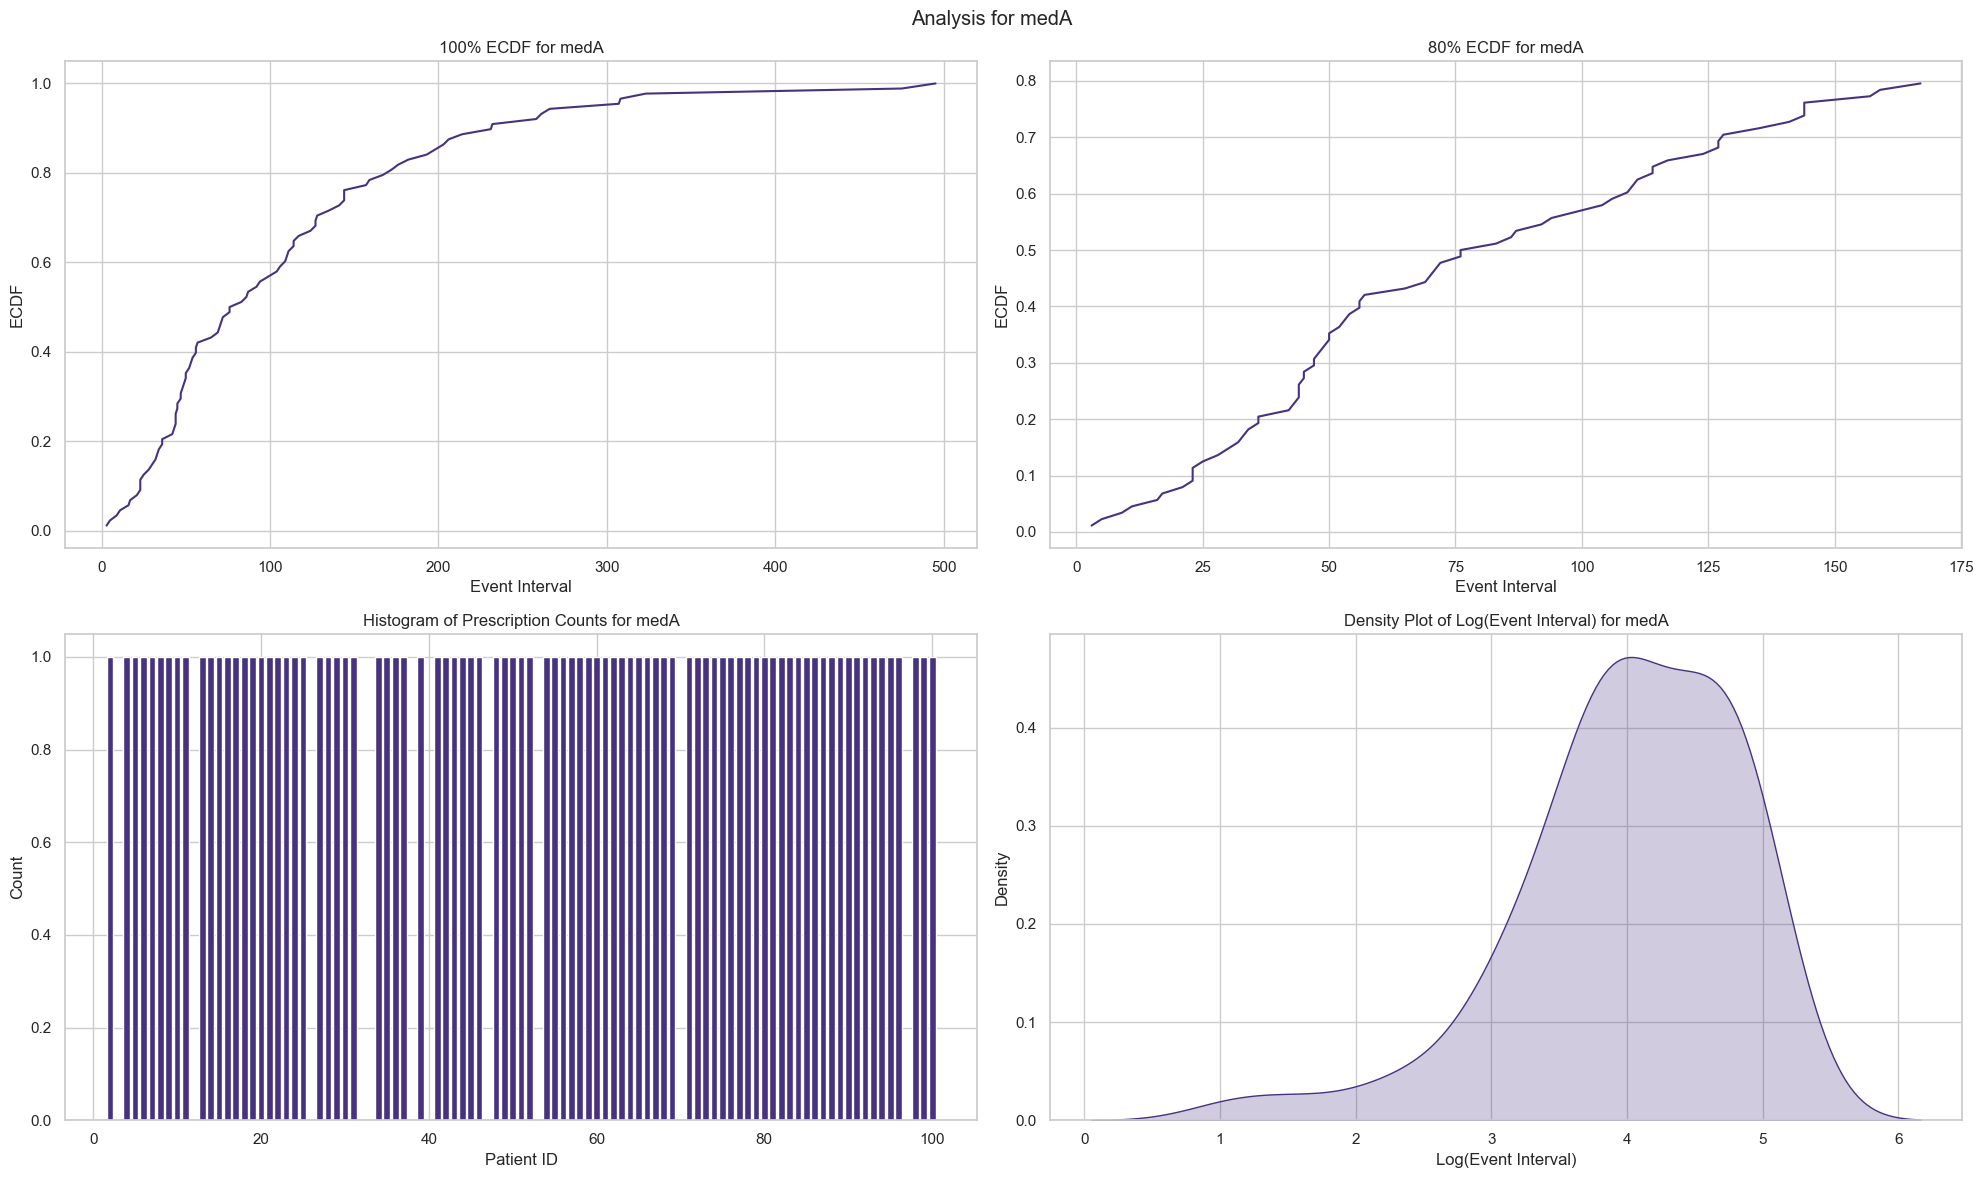

d:\anaconda\envs\cs-3202\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


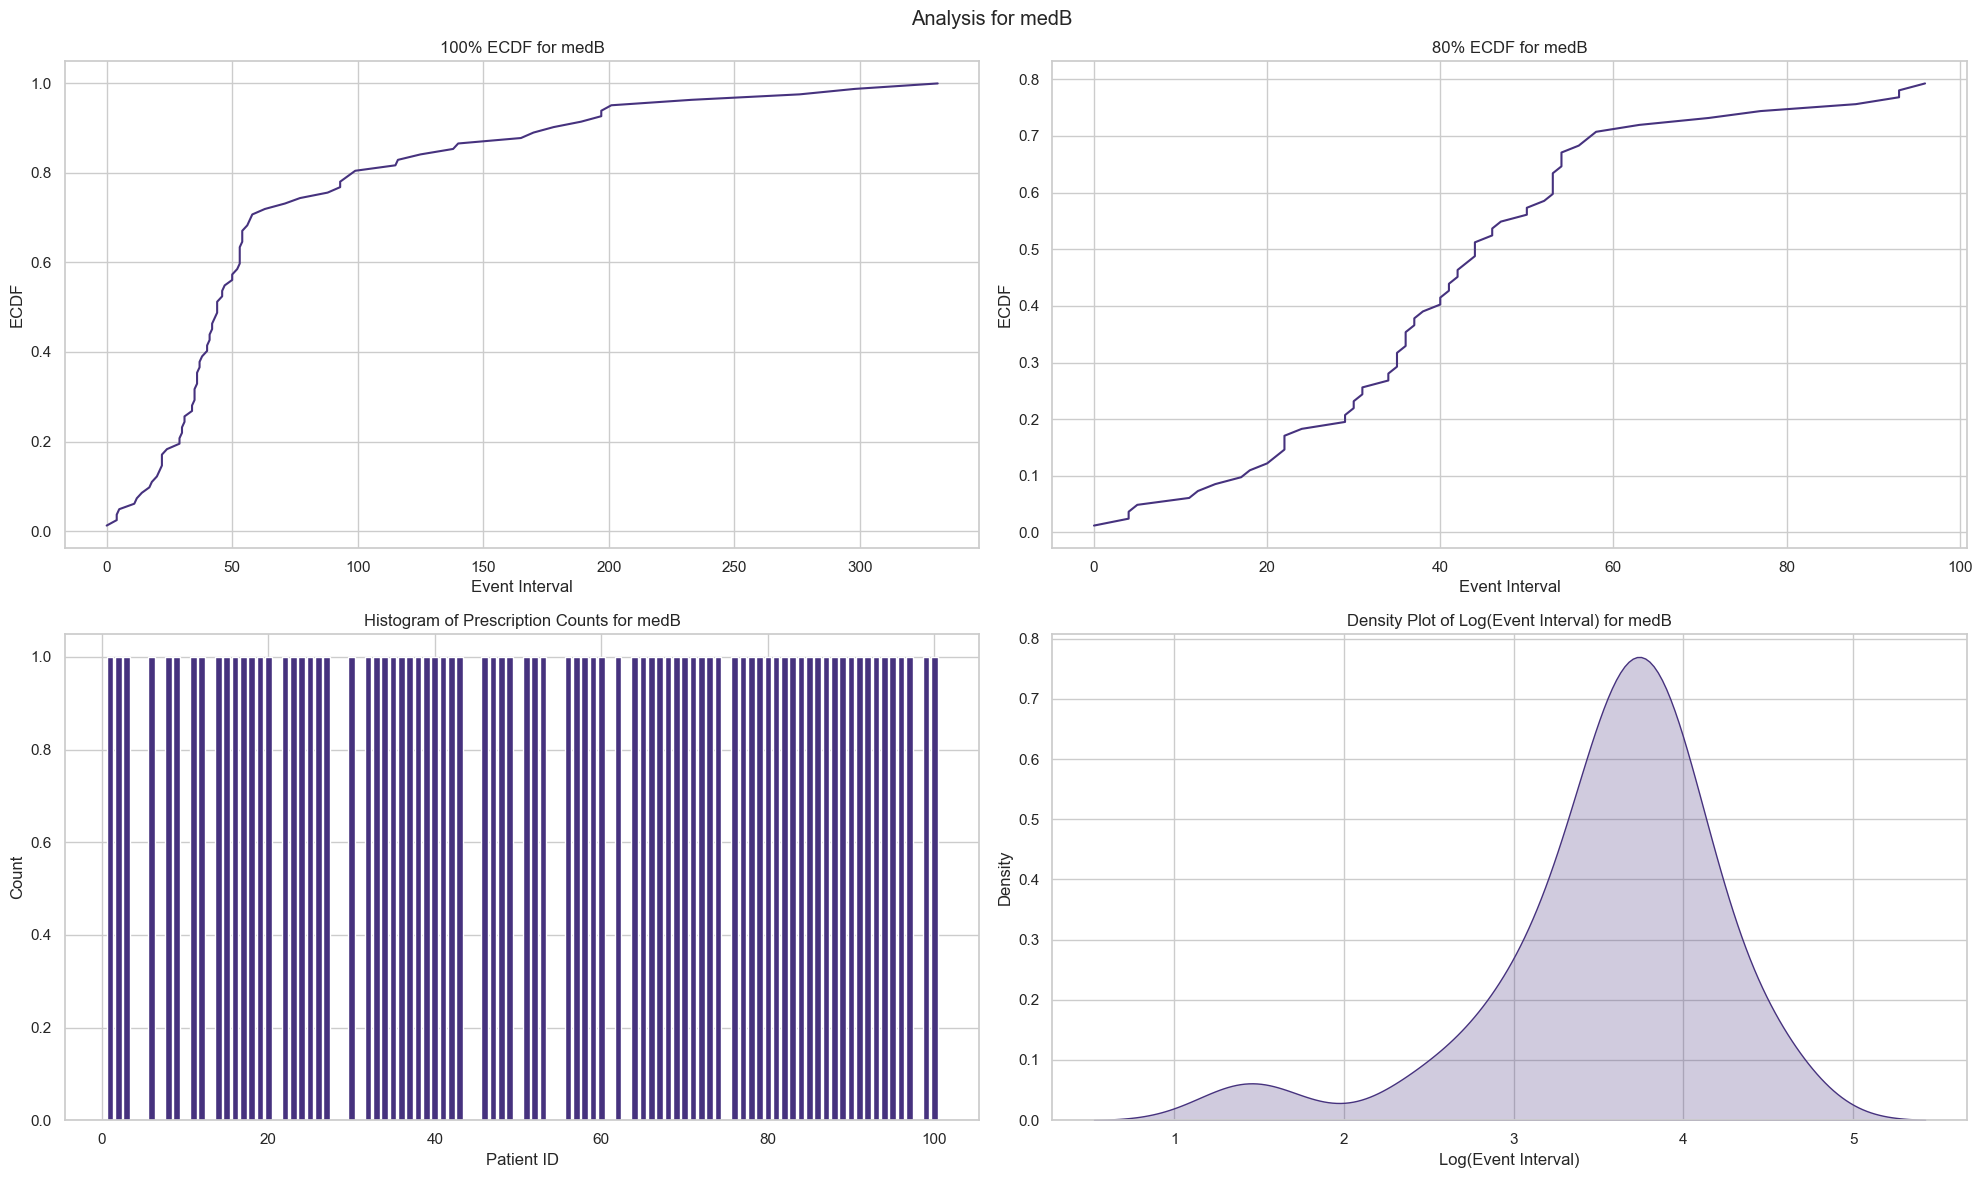

In [52]:
def see(data, drug_name):
    # Filter data for specific drug
    C09CA01 = data[data['ATC'] == drug_name].copy()

    # Sort data by patient ID and prescription date
    C09CA01 = C09CA01.sort_values(['pnr', 'eksd'])

    # Calculate previous prescription date and duration
    C09CA01['prev_eksd'] = C09CA01.groupby('pnr')['eksd'].shift(1)
    C09CA01['event.interval'] = (C09CA01['eksd'] - C09CA01['prev_eksd']).dt.days

    # Drop rows with NA in 'prev_eksd' and 'event.interval'
    C09CA01 = C09CA01.dropna(subset=['prev_eksd', 'event.interval'])

    # Randomly sample one row per patient
    Drug_see_p1 = C09CA01.groupby('pnr').sample(n=1, random_state=42)
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd', 'event.interval']]

    # Generate empirical cumulative distribution plot
    ecdf = ECDF(Drug_see_p1['event.interval'])
    x = ecdf.x
    y = ecdf.y
    
    fig, axes = plt.subplots(2, 2, figsize=(20,12))
    fig.suptitle(f"Analysis for {drug_name}")

    # Plot the 100% ECDF
    axes[0, 0].plot(x, y)
    axes[0, 0].set_title(f"100% ECDF for {drug_name}")
    axes[0, 0].set_xlabel("Event Interval")
    axes[0, 0].set_ylabel("ECDF")

    # Plot the 80% ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    dfper = dfper[dfper['y'] <= 0.8]
    axes[0, 1].plot(dfper['x'], dfper['y'])
    axes[0, 1].set_title(f"80% ECDF for {drug_name}")
    axes[0, 1].set_xlabel("Event Interval")
    axes[0, 1].set_ylabel("ECDF")

    # Create histogram of prescription counts
    m1 = Drug_see_p1['pnr'].value_counts()
    axes[1, 0].bar(m1.index, m1.values)
    axes[1, 0].set_title(f"Histogram of Prescription Counts for {drug_name}")
    axes[1, 0].set_xlabel("Patient ID")
    axes[1, 0].set_ylabel("Count")


    # Filter event intervals for density plot
    ni = dfper['x'].max()
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni]

    # Density plot of log event interval
    log_event_interval = np.log(Drug_see_p2['event.interval'])
    sns.kdeplot(log_event_interval, fill=True, ax=axes[1, 1])
    axes[1, 1].set_title(f"Density Plot of Log(Event Interval) for {drug_name}")
    axes[1, 1].set_xlabel("Log(Event Interval)")
    axes[1, 1].set_ylabel("Density")

    plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
    plt.show()

    return Drug_see_p1

medA = see(df, "medA")
medB = see(df, "medB")

### **Step 4: Prescription Duration Visualization**
The function below takes prescription data for a list of drugs:
1. Generates vertically arranged box plots to visualize the distribution of prescription durations based on the prescription number
2. Calculates the median of medians prescription duration across patients.
3. Filters the data for each specified drug
4. Calculates the duration between consecutive prescriptions
5. Adds a prescription number for each patient
6. Generates a box plot showing the distribution of these durations by prescription number

The plots are designed to display the median of medians prescription duration across patients, and are arranged horizontally to facilitate comparison across different medications.

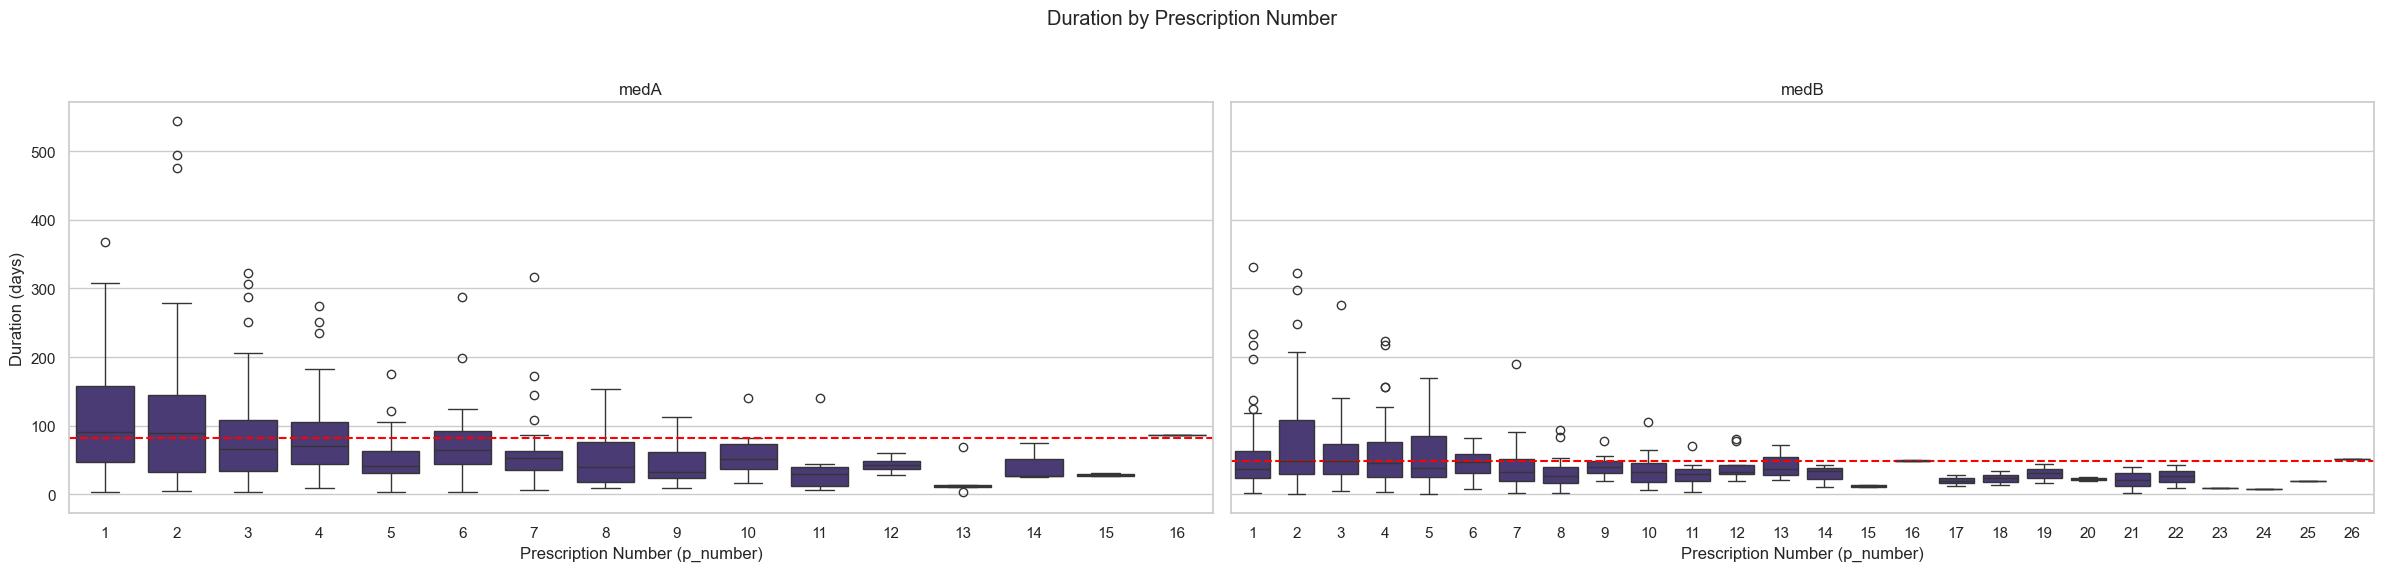

In [53]:
def see_assumption(data, drug_names):
    num_drugs = len(drug_names)

    # Create subplots - adjust rows and columns as needed
    fig, axes = plt.subplots(1, num_drugs, figsize=(12 * num_drugs, 6), sharey=True) # sharey for common y-axis
    fig.suptitle("Duration by Prescription Number") # Global title

    for i, drug_name in enumerate(drug_names):
        # Filter data for the specific drug (equivalent to tidy[which(tidy$ATC == arg_name), ])
        filtered_data = data[data['ATC'] == drug_name].copy()

        # Ensure 'eksd' is a datetime object
        filtered_data['eksd'] = pd.to_datetime(filtered_data['eksd'])

        # Sort by patient ID ('pnr') and prescription date ('eksd')
        filtered_data = filtered_data.sort_values(['pnr', 'eksd'])

        # Calculate previous prescription date ('prev_eksd') and duration ('Duration')
        filtered_data['prev_eksd'] = filtered_data.groupby('pnr')['eksd'].shift(1)
        filtered_data['Duration'] = (filtered_data['eksd'] - filtered_data['prev_eksd']).dt.days

        # Drop rows with NA in 'eksd', 'prev_eksd', or 'Duration'
        filtered_data = filtered_data.dropna(subset=['eksd', 'prev_eksd', 'Duration'])

        # Add prescription number ('p_number')
        filtered_data['p_number'] = filtered_data.groupby('pnr').cumcount() + 1

        # Remove rows with missing durations (first prescription for each patient)
        filtered_data = filtered_data.dropna(subset=['Duration'])

        # Convert 'p_number' to categorical for proper grouping in the box plot
        filtered_data['p_number'] = filtered_data['p_number'].astype('category')

        # Calculate the median of medians across patients
        medians_of_medians = (
            filtered_data.groupby('pnr')['Duration']
            .median()
            .dropna()
            .median()
        )

        # Create the box plot on the appropriate subplot
        ax = axes[i] if num_drugs > 1 else axes # Handle single plot case
        sns.boxplot(x='p_number', y='Duration', data=filtered_data, ax=ax)

        # Add a horizontal line for the median of medians
        ax.axhline(y=medians_of_medians, color='red', linestyle='--')

        # Set plot title and labels
        ax.set_title(f"{drug_name}")  # Specific title for each drug
        ax.set_xlabel("Prescription Number (p_number)")
        ax.set_ylabel("Duration (days)")


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


see_assumption(df, ["medA", "medB"])

## **Section 5: Clustering Algorithm Comparison**

### **Method 1: K-means Clustering**

This function performs an in-depth k-means clustering analysis on prescription data for a given drug. It mirrors the approach used in the R analysis by preparing the data, computing an empirical cumulative distribution function (ECDF), filtering the data, selecting the optimal number of clusters via silhouette analysis, executing k-means clustering, deriving cluster boundaries, and finally merging the cluster information back into the sample for visualization.

#### **Step-by-Step Breakdown**

1. **Filter and Sort Data:**  
   The function first filters the dataset to include only rows corresponding to the specified drug (`drug_name`) and then sorts the data by patient ID (`pnr`) and prescription date (`eksd`).
   ```python
   df_filtered = data[data['ATC'] == drug_name].copy()
   df_filtered.sort_values(['pnr', 'eksd'], inplace=True)
   ```

2. **Compute Previous Prescription Date and Event Interval:**  
   For each patient, the previous prescription date is calculated using a groupby shift operation. The event interval (in days) is then computed as the difference between the current and previous prescription dates.
   ```python
   df_filtered['prev_eksd'] = df_filtered.groupby('pnr')['eksd'].shift(1)
   df_filtered.dropna(subset=['prev_eksd'], inplace=True)
   df_filtered['event_interval'] = (df_filtered['eksd'] - df_filtered['prev_eksd']).dt.days.astype(float)
   ```

3. **Randomly Sample One Event per Patient:**  
   To avoid over-representation from patients with multiple prescriptions, one row is randomly sampled per patient.
   ```python
   sample_df = df_filtered.groupby('pnr', group_keys=False).apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)
   ```

4. **Compute the ECDF of Event Intervals:**  
   The empirical cumulative distribution function (ECDF) is computed for the event intervals from the sampled data. The ECDF values are obtained by sorting the event intervals and evaluating the ECDF function.
   ```python
   ecdf_func = ECDF(sample_df['event_interval'])
   x_vals = np.sort(sample_df['event_interval'].values)
   y_vals = ecdf_func(x_vals)
   ```

5. **Filter ECDF Data to Retain the Lower 80%:**  
   A DataFrame is created from the ECDF values, and then the data is filtered to include only those points where the cumulative probability is less than or equal to 0.8.
   ```python
   dfper = pd.DataFrame({'x': x_vals, 'y': y_vals})
   dfper = dfper[dfper['y'] <= 0.8]
   ```

6. **Visualize the ECDF:**  
   Two plots are generated side-by-side: one showing the full ECDF and the other displaying the ECDF filtered to the lower 80%.
   ```python
   plt.figure(figsize=(12, 5))
   plt.subplot(1, 2, 1)
   plt.plot(x_vals, y_vals, marker='.', linestyle='none')
   plt.title(f"Full ECDF for {drug_name}")
   plt.xlabel("Event Interval (days)")
   plt.ylabel("ECDF")
   
   plt.subplot(1, 2, 2)
   plt.plot(dfper['x'], dfper['y'], marker='.', linestyle='none')
   plt.title(f"80% ECDF for {drug_name}")
   plt.xlabel("Event Interval (days)")
   plt.ylabel("ECDF")
   plt.tight_layout()
   plt.show()
   ```

   - If the filtered ECDF (`dfper`) is empty, the function prints a message and returns the sample with missing cluster assignments.

7. **Determine Optimal Number of Clusters Using Silhouette Analysis:**  
   The function tests candidate cluster counts (from 2 to 10) on the filtered event intervals (reshaped as a 2D array) and computes the silhouette score for each. A plot of these scores is generated, and the optimal number is chosen as the one with the highest silhouette score.
   ```python
   X_filtered = dfper['x'].values.reshape(-1, 1)
   silhouette_scores = {}
   for n in range(2, 11):
       kmeans_temp = KMeans(n_clusters=n, random_state=42)
       labels_temp = kmeans_temp.fit_predict(X_filtered)
       score = silhouette_score(X_filtered, labels_temp)
       silhouette_scores[n] = score
   plt.figure(figsize=(8, 5))
   plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
   plt.title(f"Silhouette Scores for {drug_name}")
   plt.xlabel("Number of Clusters")
   plt.ylabel("Silhouette Score")
   plt.show()
   
   best_n_clusters = max(silhouette_scores, key=silhouette_scores.get)
   print(f"Optimal number of clusters (silhouette): {best_n_clusters} with score {silhouette_scores[best_n_clusters]:.2f}")
   ```

8. **Perform K-Means Clustering:**  
   With the optimal number of clusters determined, k-means clustering is performed on the filtered event intervals. Cluster labels and centers (centroids) are obtained, and these labels are added to the filtered ECDF DataFrame.
   ```python
   kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
   labels = kmeans.fit_predict(X_filtered)
   centers = kmeans.cluster_centers_
   dfper['cluster'] = labels
   ```
   
   - A scatter plot is then created to visualize the clusters on the ECDF data, with vertical dashed lines indicating the cluster centers.
   ```python
   plt.figure(figsize=(8, 5))
   plt.scatter(dfper['x'], dfper['y'], c=dfper['cluster'], cmap='viridis', s=50)
   for i, center in enumerate(centers):
       plt.axvline(x=center, color='red', linestyle='--', label=f'Center {i}' if i==0 else "")
   plt.title(f"K-Means Clustering on ECDF-filtered Data for {drug_name}")
   plt.xlabel("Event Interval (days)")
   plt.ylabel("ECDF")
   plt.legend()
   plt.show()
   ```

9. **Compute Cluster Boundaries:**  
   For each cluster, the minimum, maximum, and median of the log-transformed event intervals are calculated. These statistics are then exponentiated to revert to the original scale. The boundaries help define the range of event intervals associated with each cluster.
   ```python
   cluster_stats = []
   for cluster in sorted(dfper['cluster'].unique()):
       cluster_data = dfper[dfper['cluster'] == cluster]['x']
       log_vals = np.log(cluster_data)
       min_log = log_vals.min()
       max_log = log_vals.max()
       median_log = np.median(log_vals)
       cluster_stats.append({
           'Cluster': cluster,
           'Minimum': np.exp(min_log),
           'Maximum': np.exp(max_log),
           'Median': np.exp(median_log)
       })
   cluster_stats_df = pd.DataFrame(cluster_stats)
   print("Cluster boundaries:")
   print(cluster_stats_df)
   ```

10. **Assign Final Clusters to Sampled Data:**  
    A cross join between the sampled data and the cluster boundaries is performed. Each patient’s event interval is compared to the computed cluster boundaries, and a final cluster label is assigned if it falls within the boundaries.
    ```python
    sample_df['_key'] = 1
    cluster_stats_df['_key'] = 1
    cross = pd.merge(sample_df, cluster_stats_df, on='_key').drop('_key', axis=1)
    cross['Final_cluster'] = np.where((cross['event_interval'] >= cross['Minimum']) & 
                                      (cross['event_interval'] <= cross['Maximum']),
                                      cross['Cluster'], np.nan)
    assigned = cross.dropna(subset=['Final_cluster'])
    final_assignments = assigned[['pnr', 'Final_cluster']].drop_duplicates(subset=['pnr'])
    ```

11. **Merge Final Cluster Assignments and Apply Fallback:**  
    The final cluster assignments are merged back into the sampled data. For patients missing a cluster assignment, the most frequent cluster (mode) is used as a fallback.
    ```python
    sample_df = sample_df.merge(final_assignments, on='pnr', how='left')
    if sample_df['Final_cluster'].isna().all():
        fallback_cluster = 0
    else:
        fallback_cluster = sample_df['Final_cluster'].value_counts().idxmax()
    sample_df['Final_cluster'] = sample_df['Final_cluster'].fillna(fallback_cluster)
    sample_df = sample_df.merge(cluster_stats_df[['Cluster', 'Median']], left_on='Final_cluster', right_on='Cluster', how='left', suffixes=('', '_cluster'))
    sample_df.drop('Cluster', axis=1, inplace=True)
    sample_df.drop(columns=['_key'], inplace=True, errors='ignore')
    ```

12. **Final Visualization of Cluster Assignments:**  
    A final scatter plot displays the sampled data, with each point colored according to its final cluster assignment.
    ```python
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(sample_df)), sample_df['event_interval'], c=sample_df['Final_cluster'], cmap='viridis', s=50)
    plt.title(f"Final K-Means Cluster Assignments for {drug_name}")
    plt.xlabel("Patient Index (sampling order)")
    plt.ylabel("Event Interval (days)")
    plt.show()
    ```

13. **Return the Final Sample:**  
    The function returns the modified sample DataFrame, now augmented with the computed event intervals, final cluster assignments, and the median event interval for the assigned cluster.
    ```python
    return sample_df
    ```

- This function is applied separately for different drugs (e.g., `"medA"` and `"medB"`) to perform a comprehensive k-means clustering analysis based on their event intervals.

C:\Users\Bryan Sanchez\AppData\Local\Temp\ipykernel_34576\3842309265.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df_filtered.groupby('pnr', group_keys=False).apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)
C:\Users\Bryan Sanchez\AppData\Local\Temp\ipykernel_34576\3842309265.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df_filtered.groupby('pnr',

Optimal number of clusters (silhouette): 2 with score 0.65
Cluster boundaries:
   Cluster  Minimum  Maximum      Median
0        0     16.0     86.0   49.000000
1        1     94.0    170.0  125.984126
Optimal number of clusters (silhouette): 2 with score 0.66
Cluster boundaries:
   Cluster  Minimum  Maximum     Median
0        0      2.0     57.0  38.470768
1        1     63.0     99.0  92.000000


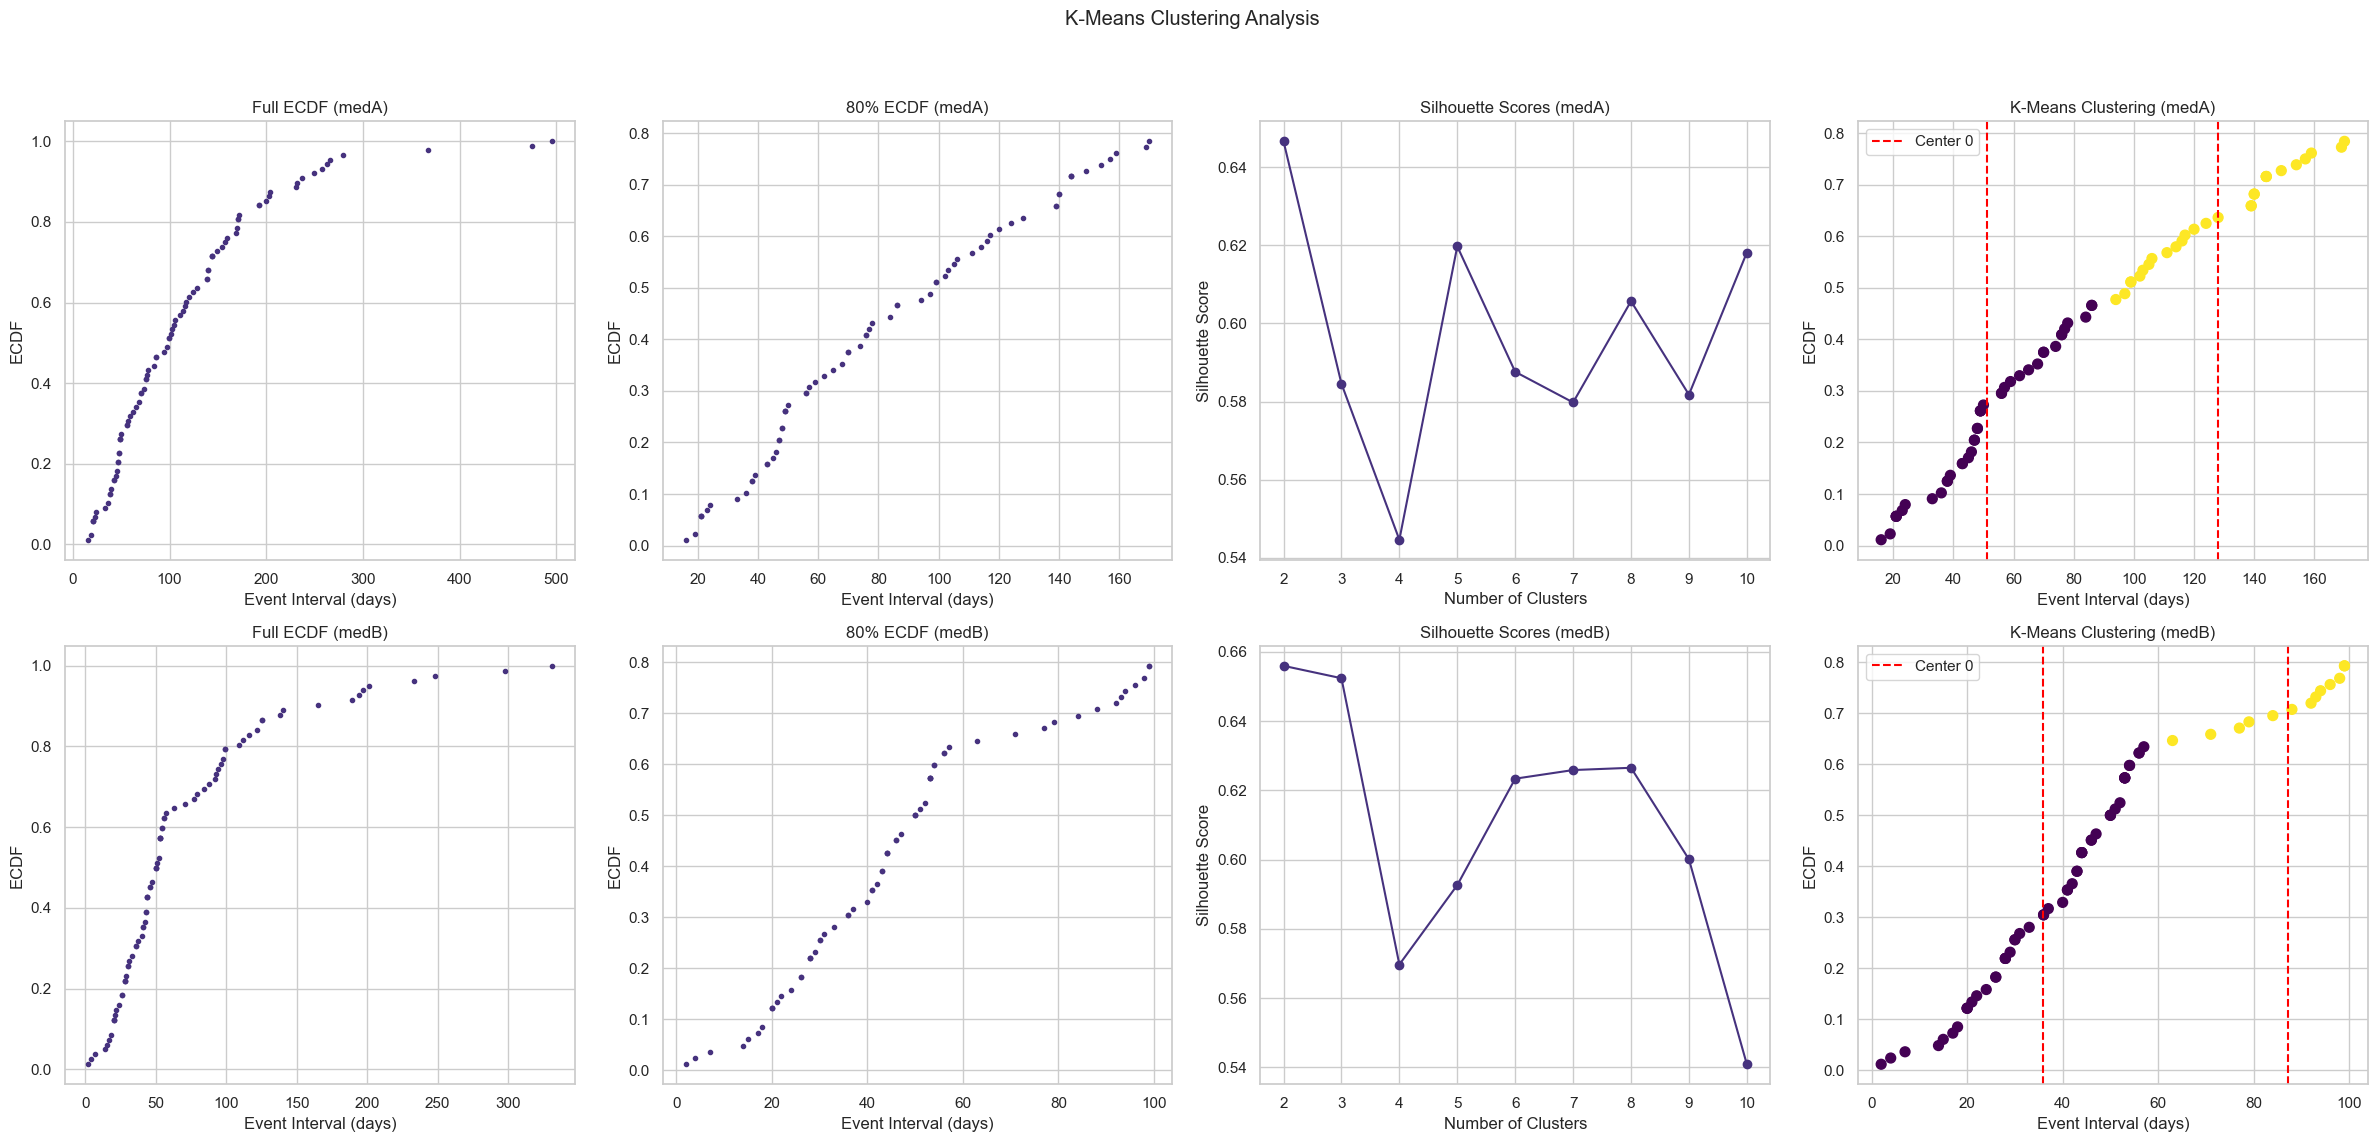

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval,Final_cluster,Median
0,1,2033-08-03,4,medB,30,2033-07-04,2.0,0.0,38.470768
1,2,2037-01-24,4,medB,60,2036-09-21,4.0,0.0,38.470768
2,3,2043-01-23,4,medB,30,2042-12-17,7.0,0.0,38.470768
3,6,2038-03-04,4,medB,30,2038-01-07,14.0,0.0,38.470768
4,8,2035-12-13,6,medB,30,2035-11-15,15.0,0.0,38.470768
...,...,...,...,...,...,...,...,...,...
77,95,2037-10-06,4,medB,30,2037-08-23,201.0,0.0,38.470768
78,96,2043-12-15,2,medB,60,2043-12-13,233.0,0.0,38.470768
79,97,2038-08-12,4,medB,60,2038-06-17,248.0,0.0,38.470768
80,99,2033-08-01,4,medB,30,2032-09-04,298.0,0.0,38.470768


In [ ]:
def k_means_clustering_analysis_full(data, drug_names): #Modified function to accept a list of drug names
    num_drugs = len(drug_names)
    # Create subplots - adjust rows and columns as needed
    fig, axes = plt.subplots(num_drugs, 4, figsize=(24, 6*num_drugs)) # increased figure size
    fig.suptitle("K-Means Clustering Analysis") # title for the entire figure

    for i, drug_name in enumerate(drug_names):
        # 1. Filter data for the drug and sort by patient and date
        df_filtered = data[data['ATC'] == drug_name].copy()
        df_filtered.sort_values(['pnr', 'eksd'], inplace=True)

        # 2. Compute previous prescription date and event interval (in days)
        df_filtered['prev_eksd'] = df_filtered.groupby('pnr')['eksd'].shift(1)
        df_filtered.dropna(subset=['prev_eksd'], inplace=True)
        df_filtered['event_interval'] = (df_filtered['eksd'] - df_filtered['prev_eksd']).dt.days.astype(float)

        # 3. Randomly sample one event per patient (mimicking R's ddply sample(n=1))
        sample_df = df_filtered.groupby('pnr', group_keys=False).apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True)

        # 4. Compute ECDF of event_interval
        ecdf_func = ECDF(sample_df['event_interval'])
        x_vals = np.sort(sample_df['event_interval'].values)
        y_vals = ecdf_func(x_vals)

        # 5. Create a DataFrame for ECDF and filter to retain lower 80%
        dfper = pd.DataFrame({'x': x_vals, 'y': y_vals})
        dfper = dfper[dfper['y'] <= 0.8]

        # 6. Visualization: Plot full ECDF and 80% ECDF
        ax1 = axes[i, 0] if num_drugs > 1 else axes[0]  # Adjust indexing
        ax1.plot(x_vals, y_vals, marker='.', linestyle='none')
        ax1.set_title(f"Full ECDF ({drug_name})")
        ax1.set_xlabel("Event Interval (days)")
        ax1.set_ylabel("ECDF")

        ax2 = axes[i, 1] if num_drugs > 1 else axes[1]  # Adjust indexing
        ax2.plot(dfper['x'], dfper['y'], marker='.', linestyle='none')
        ax2.set_title(f"80% ECDF ({drug_name})")
        ax2.set_xlabel("Event Interval (days)")
        ax2.set_ylabel("ECDF")

        if dfper.empty:
            print("No data in lower 80% of the ECDF. Returning original sample.")
            sample_df['Final_cluster'] = np.nan
            sample_df['Median'] = np.nan
            return sample_df

        # 7. Determine optimal number of clusters using silhouette analysis
        X_filtered = dfper['x'].values.reshape(-1, 1)
        silhouette_scores = {}
        for n in range(2, 11):
            kmeans_temp = KMeans(n_clusters=n, random_state=42, n_init = 'auto')
            labels_temp = kmeans_temp.fit_predict(X_filtered)
            score = silhouette_score(X_filtered, labels_temp)
            silhouette_scores[n] = score
        # Plot silhouette scores
        ax3 = axes[i, 2] if num_drugs > 1 else axes[2]  # Adjust indexing
        ax3.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
        ax3.set_title(f"Silhouette Scores ({drug_name})")
        ax3.set_xlabel("Number of Clusters")
        ax3.set_ylabel("Silhouette Score")

        best_n_clusters = max(silhouette_scores, key=silhouette_scores.get)
        print(f"Optimal number of clusters (silhouette): {best_n_clusters} with score {silhouette_scores[best_n_clusters]:.2f}")

        # 8. Perform k-means clustering on the filtered event intervals
        kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init = 'auto')
        labels = kmeans.fit_predict(X_filtered)
        centers = kmeans.cluster_centers_
        dfper['cluster'] = labels

        # Visualization: Scatter plot of clustering on filtered data
        ax4 = axes[i, 3] if num_drugs > 1 else axes[3]  # Adjust indexing
        ax4.scatter(dfper['x'], dfper['y'], c=dfper['cluster'], cmap='viridis', s=50)
        for j, center in enumerate(centers):
            ax4.axvline(x=center, color='red', linestyle='--', label=f'Center {j}' if j==0 else "")
        ax4.set_title(f"K-Means Clustering ({drug_name})")
        ax4.set_xlabel("Event Interval (days)")
        ax4.set_ylabel("ECDF")
        ax4.legend()

        # 9. For each cluster, compute min, max, and median on the log scale and exponentiate
        cluster_stats = []
        for cluster in sorted(dfper['cluster'].unique()):
            cluster_data = dfper[dfper['cluster'] == cluster]['x']
            log_vals = np.log(cluster_data)
            min_log = log_vals.min()
            max_log = log_vals.max()
            median_log = np.median(log_vals)
            cluster_stats.append({
                'Cluster': cluster,
                'Minimum': np.exp(min_log),
                'Maximum': np.exp(max_log),
                'Median': np.exp(median_log)
            })
        cluster_stats_df = pd.DataFrame(cluster_stats)
        print("Cluster boundaries:")
        print(cluster_stats_df)

        # 10. Cross join the sampled data with cluster boundaries and assign final clusters
        sample_df['_key'] = 1
        cluster_stats_df['_key'] = 1
        cross = pd.merge(sample_df, cluster_stats_df, on='_key').drop('_key', axis=1)
        cross['Final_cluster'] = np.where((cross['event_interval'] >= cross['Minimum']) &
                                          (cross['event_interval'] <= cross['Maximum']),
                                          cross['Cluster'], np.nan)
        assigned = cross.dropna(subset=['Final_cluster'])
        final_assignments = assigned[['pnr', 'Final_cluster']].drop_duplicates(subset=['pnr'])

        # 11. Merge final cluster assignments; assign fallback if missing
        sample_df = sample_df.merge(final_assignments, on='pnr', how='left')
        if sample_df['Final_cluster'].isna().all():
            fallback_cluster = 0
        else:
            fallback_cluster = sample_df['Final_cluster'].value_counts().idxmax()
        sample_df['Final_cluster'] = sample_df['Final_cluster'].fillna(fallback_cluster)
        sample_df = sample_df.merge(cluster_stats_df[['Cluster', 'Median']], left_on='Final_cluster', right_on='Cluster', how='left', suffixes=('', '_cluster'))
        sample_df.drop('Cluster', axis=1, inplace=True)
        sample_df.drop(columns=['_key'], inplace=True, errors='ignore')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for global title
    plt.show()

    return sample_df

k_means_clustering_analysis_full(df, ["medA", "medB"])


### **Method 2: Hierarchical Clustering**

This function performs a hierarchical clustering analysis on prescription data for a specified drug. It uses the average event interval per patient as the basis for clustering and visualizes the results with a dendrogram. 

#### **Step-by-Step Breakdown**
 
1. **Filter Data for the Specified Drug:**  
   ```python
   filtered_data = data[data['ATC'] == drug_name].copy()
   ```  
   - The function first filters the input DataFrame to include only rows where the `ATC` column matches the given `drug_name`.

2. **Calculate Previous Prescription Date and Event Interval:**  
   ```python
   filtered_data['prev_eksd'] = filtered_data.groupby('pnr')['eksd'].shift(1)
   filtered_data['event.interval'] = (filtered_data['eksd'] - filtered_data['prev_eksd']).dt.days
   ```  
   - For each patient (grouped by `pnr`), the previous prescription date is computed using the `shift()` function.
   - The event interval (in days) is calculated as the difference between the current prescription date (`eksd`) and the previous one (`prev_eksd`).

3. **Remove Incomplete Records:**  
   ```python
   filtered_data = filtered_data.dropna(subset=['prev_eksd', 'event.interval'])
   ```  
   - Any rows where the previous prescription date or event interval is missing are dropped.

4. **Compute Average Event Interval per Patient:**  
   ```python
   avg_interval = filtered_data.groupby('pnr')['event.interval'].mean().dropna()
   X = avg_interval.values.reshape(-1, 1)
   ```  
   - The average event interval is computed for each patient. This value summarizes each patient’s prescription pattern.
   - The resulting series is reshaped into a 2D array (`X`) as required by the clustering algorithm.

5. **Perform Hierarchical Clustering:**  
   ```python
   linked = linkage(X, method='ward')
   ```  
   - The hierarchical clustering is performed on the average event intervals using Ward's method. This method minimizes the total within-cluster variance.

6. **Plot the Dendrogram:**  
   ```python
   plt.figure(figsize=(12, 6))
   dendrogram(linked, orientation='top', distance_sort='descending', 
              show_leaf_counts=True, labels=avg_interval.index)
   plt.title(f"Dendrogram for Hierarchical Clustering ({drug_name})")
   plt.xlabel("Patient (pnr)")
   plt.ylabel("Distance")
   plt.show()
   ```  
   - A dendrogram is plotted to visualize the hierarchical clustering structure.
   - Patient IDs (from the index of `avg_interval`) are used as labels, providing context on which patients are grouped together.

7. **Determine Clusters Using a Distance Threshold:**  
   ```python
   clusters = fcluster(linked, t=5, criterion='distance')
   ```  
   - The flat clusters are determined by cutting the dendrogram at a specified distance threshold (`t=5`). Adjusting `t` changes the number of clusters.

8. **Map Cluster Labels Back to Patients:**  
   ```python
   clusters_df = pd.DataFrame({'pnr': avg_interval.index, 'cluster': clusters})
   filtered_data = filtered_data.merge(clusters_df, on='pnr', how='left')
   ```  
   - A new DataFrame (`clusters_df`) is created to map each patient (`pnr`) to their respective cluster label.
   - This mapping is then merged back into the original filtered data.

9. **Print and Return the Cluster Distribution:**  
   ```python
   print("Cluster Distribution:")
   print(filtered_data['cluster'].value_counts())
   return filtered_data
   ```  
   - The function prints the distribution of patients across the clusters.
   - Finally, it returns the filtered data with the cluster labels added.

Cluster Distribution for medA:
cluster
9     63
10    48
11    41
15    32
2     25
12    20
3     19
7     17
16    17
14    16
17    16
1     15
13    14
4     12
18    12
6     11
23     9
19     9
20     7
21     7
27     6
28     5
25     5
22     5
8      5
31     3
29     3
24     3
26     2
30     1
5      1
Name: count, dtype: int64
Cluster Distribution for medB:
cluster
11    74
10    57
13    37
24    35
25    29
12    27
8     27
27    25
7     22
19    21
26    19
21    13
20    10
22     6
16     5
17     5
2      3
23     2
9      2
5      2
3      2
4      2
15     2
1      1
18     1
14     1
6      1
Name: count, dtype: int64


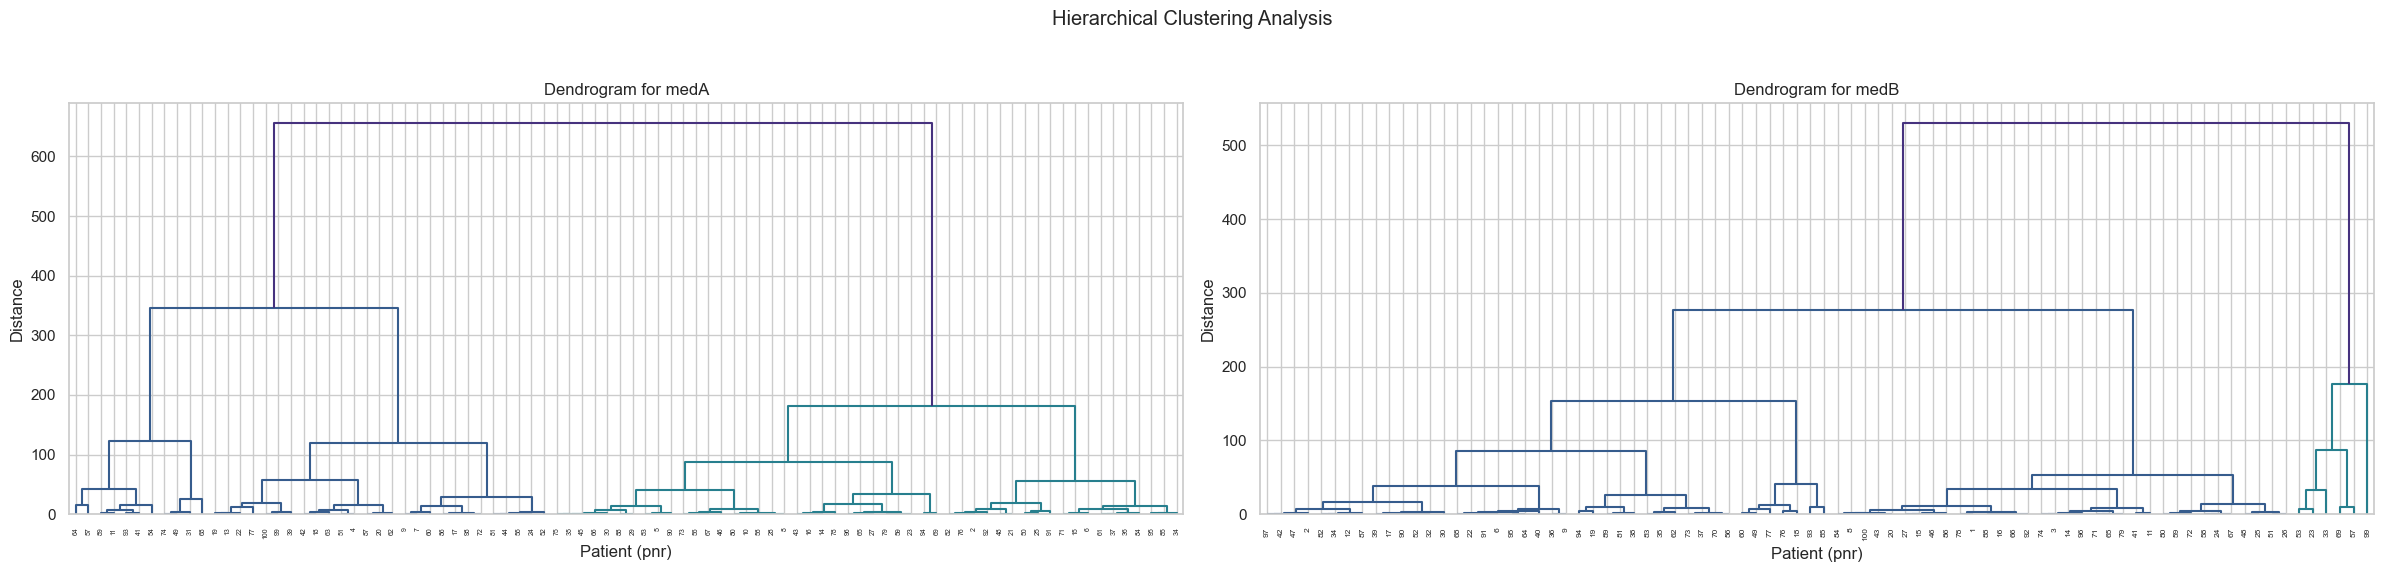

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,cluster
0,1,2033-08-03,4,medB,30,2033-07-04,30.0,11
1,1,2033-08-17,4,medB,30,2033-08-03,14.0,11
2,1,2033-10-13,4,medB,30,2033-08-17,57.0,11
3,1,2033-10-16,4,medB,30,2033-10-13,3.0,11
4,1,2033-11-23,4,medB,30,2033-10-16,38.0,11
...,...,...,...,...,...,...,...,...
426,100,2034-03-05,6,medB,30,2034-01-22,42.0,13
427,100,2034-04-07,6,medB,30,2034-03-05,33.0,13
428,100,2034-04-26,6,medB,30,2034-04-07,19.0,13
429,100,2034-05-26,6,medB,30,2034-04-26,30.0,13


In [57]:
def hierarchical_clustering_analysis(data, drug_names):
    num_drugs = len(drug_names)

    # Create subplots - adjust rows and columns as needed
    fig, axes = plt.subplots(1, num_drugs, figsize=(12 * num_drugs, 6)) #Adjusted to one row and several columns
    fig.suptitle("Hierarchical Clustering Analysis")  # Overall title

    for i, drug_name in enumerate(drug_names):
        # Filter data for specific drug
        filtered_data = data[data['ATC'] == drug_name].copy()

        # Calculate previous prescription date and event interval
        filtered_data['prev_eksd'] = filtered_data.groupby('pnr')['eksd'].shift(1)
        filtered_data['event.interval'] = (filtered_data['eksd'] - filtered_data['prev_eksd']).dt.days

        # Drop rows with NA in 'prev_eksd' and 'event.interval'
        filtered_data = filtered_data.dropna(subset=['prev_eksd', 'event.interval'])

        # Compute average event interval per patient
        avg_interval = filtered_data.groupby('pnr')['event.interval'].mean().dropna()
        X = avg_interval.values.reshape(-1, 1)

        # Perform hierarchical clustering using Ward's method
        linked = linkage(X, method='ward')

        # Plot dendrogram, labeling by patient IDs
        ax = axes[i] if num_drugs > 1 else axes  # Handle single drug case
        dendrogram(linked, orientation='top', distance_sort='descending',
                   show_leaf_counts=True, labels=avg_interval.index, ax=ax)  # Pass axes
        ax.set_title(f"Dendrogram for {drug_name}")
        ax.set_xlabel("Patient (pnr)")
        ax.set_ylabel("Distance")

        # Determine clusters using a distance threshold (adjust 't' as needed)
        clusters = fcluster(linked, t=5, criterion='distance')

        # Create a DataFrame mapping patient IDs to their cluster labels
        clusters_df = pd.DataFrame({'pnr': avg_interval.index, 'cluster': clusters})

        # Merge cluster labels back into the original data
        filtered_data = filtered_data.merge(clusters_df, on='pnr', how='left')

        # Print cluster distribution
        print(f"Cluster Distribution for {drug_name}:")
        print(filtered_data['cluster'].value_counts())

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.show()

    return filtered_data

hierarchical_clustering_analysis(df, ["medA", "medB"])


# **References**
- [Pubmed Central - Rationale and performances of a data-driven method for computing the duration of pharmacological prescriptions using secondary data sources](https://pmc.ncbi.nlm.nih.gov/articles/PMC9012860)